# **Regression**

## Objectives

* Fit and evaluate a "Regression Model" to predict "SalePrice"

## Inputs

* "outputs/datasets/collection/cleaned/CleanedHousePrices.csv"

## Outputs

* TrainSet
* TestSet
* Modeling Pipeline
* Features Importance Plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/P5-Heritage-Housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/P5-Heritage-Housing'

# Loading of Data

In [4]:
import numpy as np
import pandas as pd
cleaned_house_prices_df = pd.read_csv("/workspace/P5-Heritage-Housing/outputs/datasets/collection/cleaned/CleanedHousePrices.csv")
print(cleaned_house_prices_df.shape)
cleaned_house_prices_df.head(3)

(1460, 22)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


---

# ML Pipeline: Regressor

## Creation of ML Pipeline

### Packages

In [5]:
# For Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# For Feature Scaling
from sklearn.preprocessing import StandardScaler

# For Feature Selection
from sklearn.feature_selection import SelectFromModel

# For ML Algorithms
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [6]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                 variables=['KitchenQual', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

---

### Hyperparameter Optimization

- Custom Class is taken from "Scikit-Learn Unit 9B: NLP(Natural Language Processing) Best Algoritm Hyperparameters" lesson.

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

### Splitting Dataset to TrainSet and TestSet

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_house_prices_df.drop(['SalePrice'], axis=1),
    cleaned_house_prices_df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* TrainSet:", X_train.shape, y_train.shape,
      "\n* TestSet:",  X_test.shape, y_test.shape)

* TrainSet: (1168, 21) (1168,) 
* TestSet: (292, 21) (292,)


- Check Train Set Target Distribution

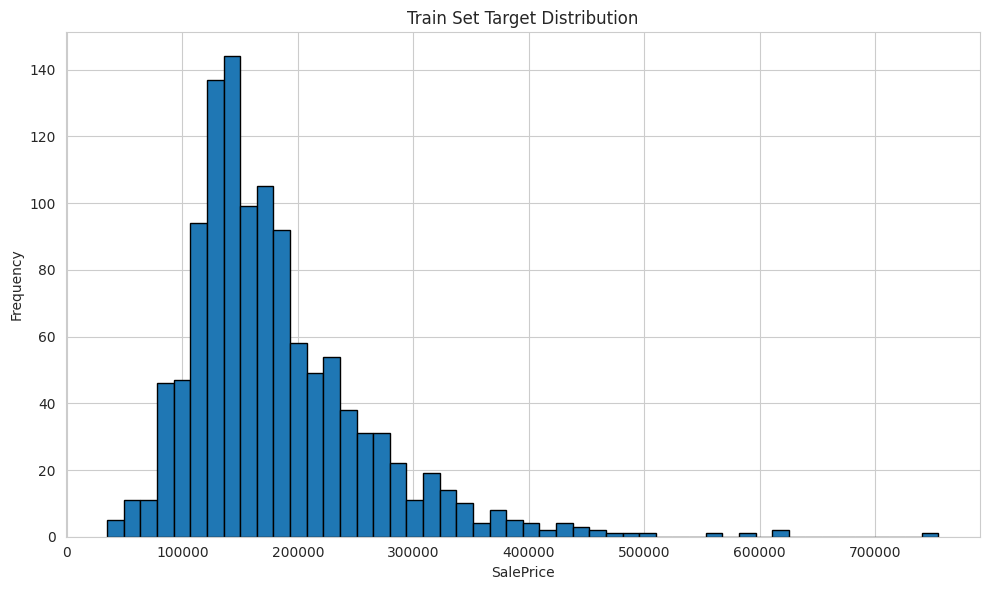

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

plt.hist(y_train, bins=50, edgecolor='black')


plt.title('Train Set Target Distribution')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Grid Search CV

- GridSearchCV is a tool in scikit-learn library used to find the best hyperparameters for a model.

In [12]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [13]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [14]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.643137,0.772857,0.834133,0.067405
3,ExtraTreesRegressor,0.682734,0.766507,0.805553,0.042962
2,RandomForestRegressor,0.618654,0.762363,0.822354,0.073567
0,LinearRegression,0.7225,0.761412,0.830006,0.038917
4,AdaBoostRegressor,0.507389,0.673009,0.789042,0.098587
6,XGBRegressor,0.554363,0.653108,0.710833,0.056162
1,DecisionTreeRegressor,0.355924,0.531838,0.650633,0.111503


#### Extensive Search

In [15]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    'LinearRegression': LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [7, 10, 20],
        'model__max_depth': [3,7,10],
        'model__min_samples_split': [5,7],

    },

    "ExtraTreesRegressor":{
        'model__n_estimators': [7],
        'model__max_depth': [3,7],
        'model__min_samples_split': [4,5,7],
    },
    
    'LinearRegression': {},
    
    "RandomForestRegressor": {
        'model__n_estimators': [7],
        'model__max_depth': [3,7,10],
        'model__min_samples_split': [4,5,7],
    },
}

In [16]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=6)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 6 folds for each of 6 candidates, totalling 36 fits



Running GridSearchCV for GradientBoostingRegressor 

Fitting 6 folds for each of 18 candidates, totalling 108 fits

Running GridSearchCV for LinearRegression 

Fitting 6 folds for each of 1 candidates, totalling 6 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 6 folds for each of 9 candidates, totalling 54 fits


In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
17,GradientBoostingRegressor,0.642518,0.753641,0.805669,0.053226,7,7,20
14,GradientBoostingRegressor,0.64539,0.751875,0.795687,0.050787,7,5,20
24,LinearRegression,0.616022,0.74968,0.817007,0.06982,NaN,NaN,NaN
23,GradientBoostingRegressor,0.654715,0.747601,0.801297,0.047542,10,7,20
4,ExtraTreesRegressor,0.613385,0.737436,0.808502,0.060008,7,5,7
20,GradientBoostingRegressor,0.626551,0.735966,0.79845,0.053745,10,5,20
11,GradientBoostingRegressor,0.583519,0.731374,0.804353,0.075256,3,7,20
8,GradientBoostingRegressor,0.583519,0.731374,0.804353,0.075256,3,5,20
3,ExtraTreesRegressor,0.570455,0.726893,0.777038,0.071549,7,4,7
5,ExtraTreesRegressor,0.598037,0.721298,0.774648,0.062765,7,7,7


In [18]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [19]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'GarageFinish',
                                           'BsmtFinType1', 'BsmtExposure'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['1stFlrSF', 'GrLivArea',
                                                  'LotArea', 'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(max_depth=7, min_samples_split=7,
                                           n_estimators=20, random_state=0))])

#### Assess Feature Importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', '2ndFlrSF']


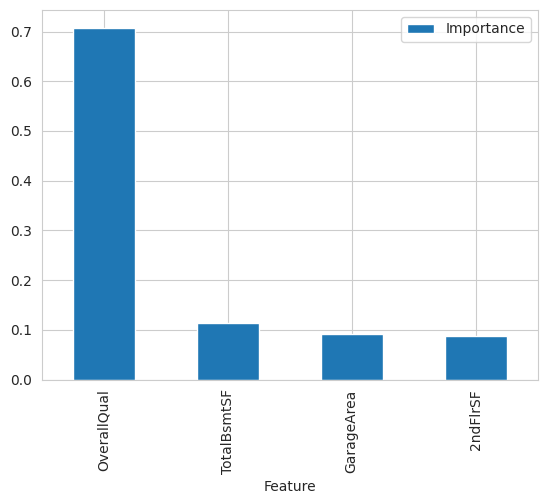

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 3
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.928
Mean Absolute Error: 15561.373
Mean Squared Error: 441000904.672
Root Mean Squared Error: 21000.022


* Test Set
R2 Score: 0.778
Mean Absolute Error: 23703.527
Mean Squared Error: 1536210354.431
Root Mean Squared Error: 39194.519




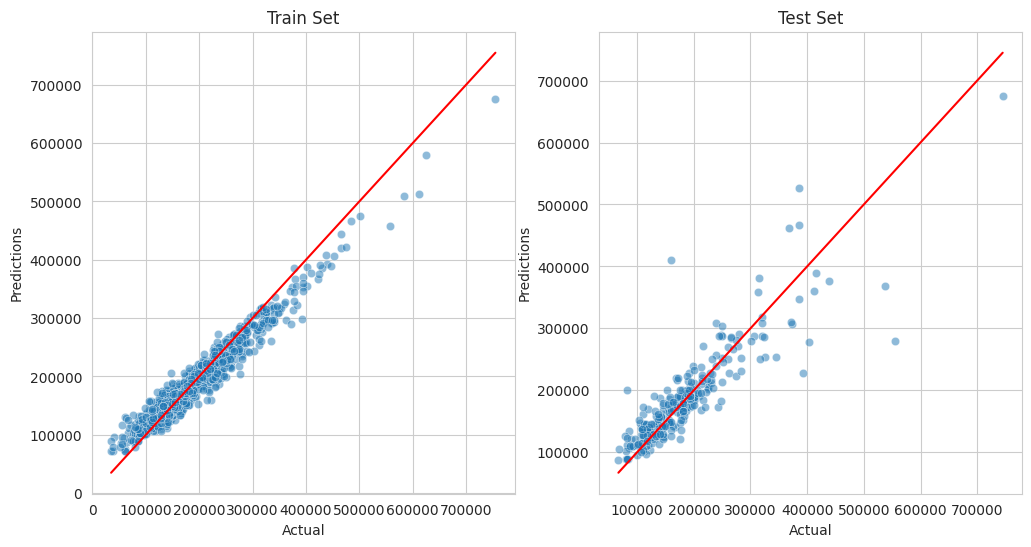

In [22]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

#### **Observations**
- Training Set performance: R² value of 0.928 (92.8%) is very good, our model can explain about 93% of the variance in the training data
- Test Set performance: R² value of 0.778 (77.8%) is reasonable, but shows a drop from training set
#### Evaluation:
- There's a significant performance gap between training and test sets:
- Overall, the model performance is acceptable but has room for improvement. The main focus should be on reducing the gap between training and test performance. The R² score of 0.778 on the test set means your model explains about 78% of the variance in the target variable, which is decent for many real-world applications, but the overfitting issue should be addressed for more robust predictions. We will try to easier pipeline to reach results.

### Rewrite Pipeline

In [23]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                 variables=['KitchenQual', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

In [24]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [25]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


---

In [26]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.672712,0.804695,0.874444,0.07442
0,LinearRegression,0.700438,0.786672,0.819273,0.045388
2,RandomForestRegressor,0.632989,0.785848,0.85964,0.08142
5,GradientBoostingRegressor,0.635656,0.754929,0.850056,0.085652
6,XGBRegressor,0.637822,0.748435,0.824044,0.068439
4,AdaBoostRegressor,0.620702,0.737763,0.798809,0.068591
1,DecisionTreeRegressor,0.495511,0.630795,0.730248,0.079435


In [27]:
models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [7],
        'model__max_depth': [7],
        'model__min_samples_split': [7],
    },

}

In [28]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=6)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 6 folds for each of 1 candidates, totalling 6 fits


In [33]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [34]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 7,
 'model__min_samples_split': 7,
 'model__n_estimators': 7}

In [35]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'GarageFinish',
                                           'BsmtFinType1', 'BsmtExposure'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=7, min_samples_split=7,
                                     n_estimators=7, random_state=0))])

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea']


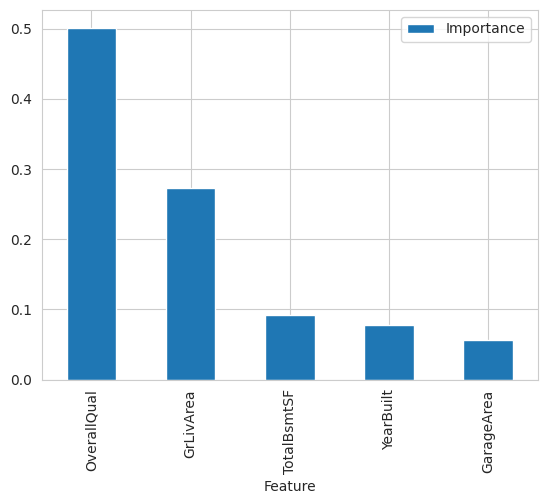

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.901
Mean Absolute Error: 17614.303
Mean Squared Error: 610931610.731
Root Mean Squared Error: 24717.031


* Test Set
R2 Score: 0.86
Mean Absolute Error: 19424.068
Mean Squared Error: 966526052.289
Root Mean Squared Error: 31089.002




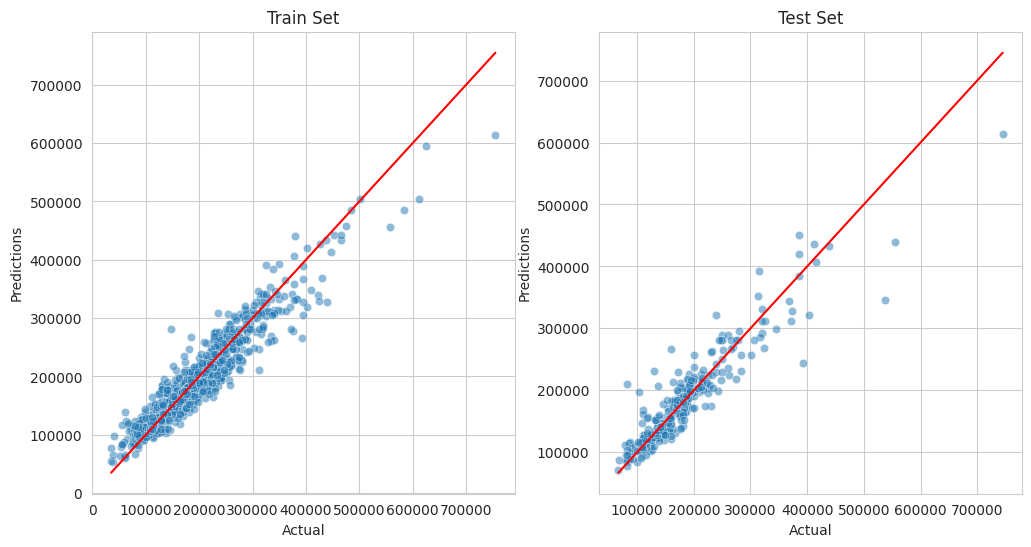

In [37]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

### **Observations**
Model Balance: This model shows better balance between training and test performance compared to the previous one:
- Train R² (0.901) is closer to Test R² (0.86)
- The gap between Train RMSE (24,717) and Test RMSE (31,089) is smaller
#### **Improvements from Previous Model:**
- Test R² improved from 0.778 to 0.86
- The overfitting issue has been significantly reduced
- More consistent performance across both sets
#### **Overall**
- This is a good model with strong predictive power
- Explains 86% of variance in test data
- The relatively small gap between train and test metrics
- This model shows much better characteristics than the previous one, with less overfitting and better generalization. The high R² scores in both training and test sets, combined with the relatively small gap between them, indicate a robust and reliable model.

## ML with PCA

In [38]:
pipeline = PipelineOptimization(model=ExtraTreesRegressor())
pipeline_pca = Pipeline(pipeline.steps[:2])
df_pca = pipeline_pca.fit_transform(cleaned_house_prices_df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(1460, 17) 
 <class 'pandas.core.frame.DataFrame'>


* The 17 components explain 100.0% of the data 



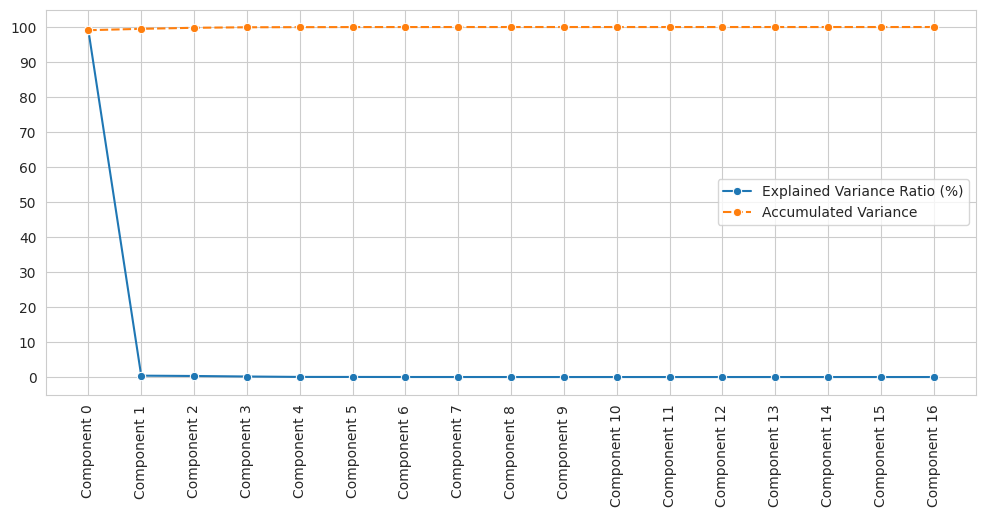

In [39]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 17


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 7 components explain 99.99% of the data 



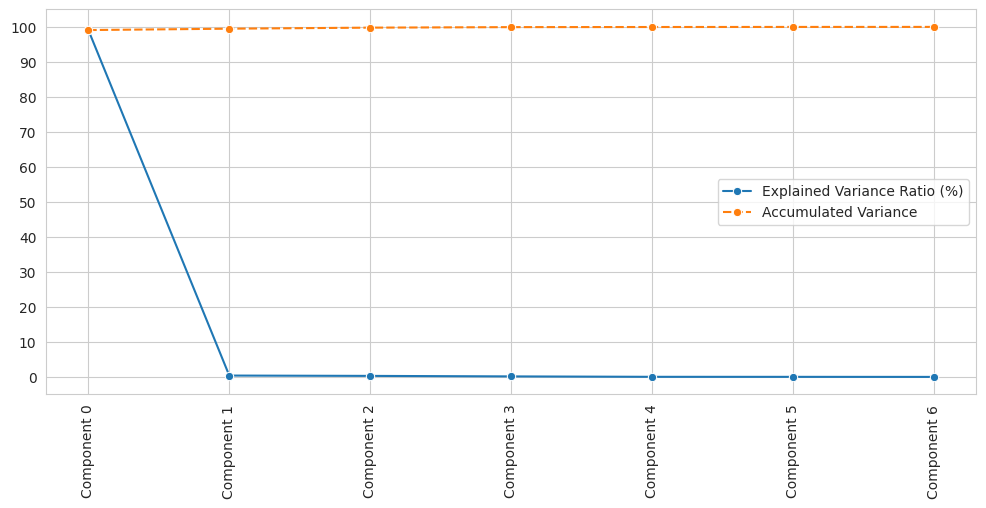

In [40]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

In [41]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual', 'GarageFinish', 'BsmtFinType1', 'BsmtExposure'])),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

In [42]:
print("* TrainSet:", X_train.shape, y_train.shape, "\n* TestSet:",  X_test.shape, y_test.shape)

* TrainSet: (1168, 21) (1168,) 
* TestSet: (292, 21) (292,)


In [43]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [44]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [45]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.732028,0.780804,0.832588,0.037495
3,ExtraTreesRegressor,0.673468,0.771821,0.845251,0.064144
5,GradientBoostingRegressor,0.633659,0.761763,0.825484,0.070233
0,LinearRegression,0.669533,0.748819,0.7913,0.045041
6,XGBRegressor,0.662994,0.74099,0.80677,0.053472
4,AdaBoostRegressor,0.634629,0.724479,0.788879,0.050089
1,DecisionTreeRegressor,0.464468,0.571638,0.703538,0.094982


In [46]:
pca_models_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    
}

pca_params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [6],
        'model__max_depth': [8],
        'model__min_samples_split': [4],
    }
}

In [47]:
search = HyperparameterOptimizationSearch(models=pca_models_search, params=pca_params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [48]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.685542,0.760202,0.816859,0.04482,8,4,6


In [49]:
best_model_pca = grid_search_summary.iloc[0,0]
best_model_pca

'ExtraTreesRegressor'

In [50]:
best_pca_regressor_pipeline = grid_search_pipelines[best_model_pca].best_estimator_
best_pca_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual', 'GarageFinish',
                                           'BsmtFinType1', 'BsmtExposure'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model',
                 ExtraTreesRegressor(max_depth=8, min_samples_split=4,
                                     n_estimators=6, random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.908
Mean Absolute Error: 16785.188
Mean Squared Error: 566540029.121
Root Mean Squared Error: 23802.101


* Test Set
R2 Score: 0.756
Mean Absolute Error: 23720.011
Mean Squared Error: 1682542218.755
Root Mean Squared Error: 41018.803




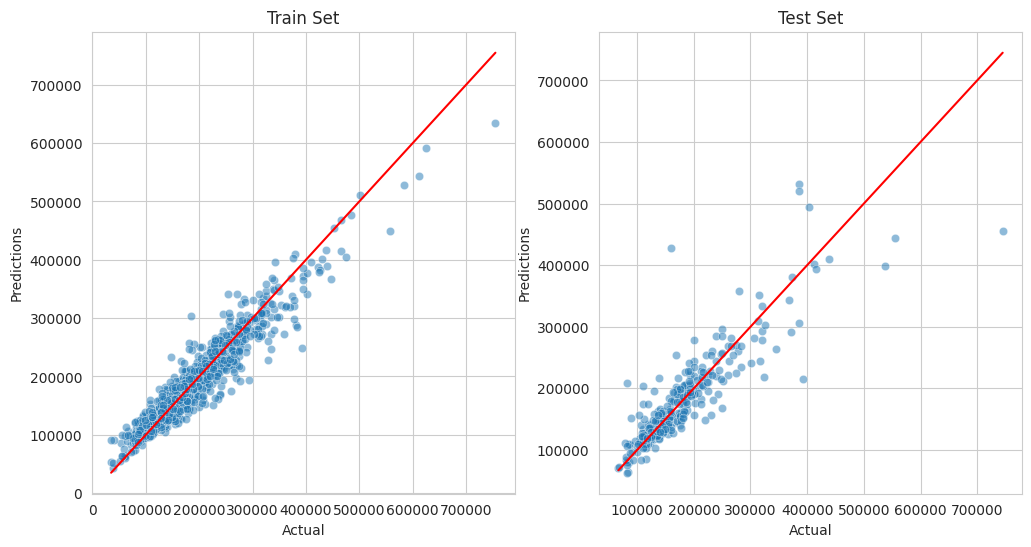

In [51]:
regression_performance(X_train, y_train, X_test, y_test,best_pca_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_pca_regressor_pipeline)

### Conclusion and Chosen Pipeline

#### The regression without feature engineering model is better because:
- More balanced performance between train and test sets
- Better generalization
- More reliable predictions on unseen data
- Less overfitting
- It shows more robust and reliable performance.


### Refit Chosen Pipeline

In [55]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base

### Split Train and Test Sets With Best Features

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    cleaned_house_prices_df.drop(['SalePrice'],axis=1),
                                    cleaned_house_prices_df['SalePrice'],
                                    test_size = 0.2,
                                    random_state = 0,
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 21) (1168,) (292, 21) (292,)


- Let's see best features again.

In [57]:
best_features

['GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']

In [59]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* TrainSet:", X_train.shape, y_train.shape, "\n* TestSet:",  X_test.shape, y_test.shape)
X_train.head(3)

* TrainSet: (1168, 5) (1168,) 
* TestSet: (292, 5) (292,)


,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921


### Grid Search CV - Sklearn

In [60]:
models_search

{'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0)}

In [61]:
params_search = {
    "ExtraTreesRegressor":{
        'model__n_estimators': [7],
        'model__max_depth': [7],
        'model__min_samples_split': [7],
    }
}
params_search

{'ExtraTreesRegressor': {'model__n_estimators': [7],
  'model__max_depth': [7],
  'model__min_samples_split': [7]}}

In [62]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [63]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.665711,0.796009,0.872033,0.070952,7,7,7


In [64]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [65]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=7, min_samples_split=7,
                                     n_estimators=7, random_state=0))])

Model Evaluation 

* Train Set
R2 Score: 0.901
Mean Absolute Error: 17614.303
Mean Squared Error: 610931610.731
Root Mean Squared Error: 24717.031


* Test Set
R2 Score: 0.86
Mean Absolute Error: 19424.068
Mean Squared Error: 966526052.289
Root Mean Squared Error: 31089.002




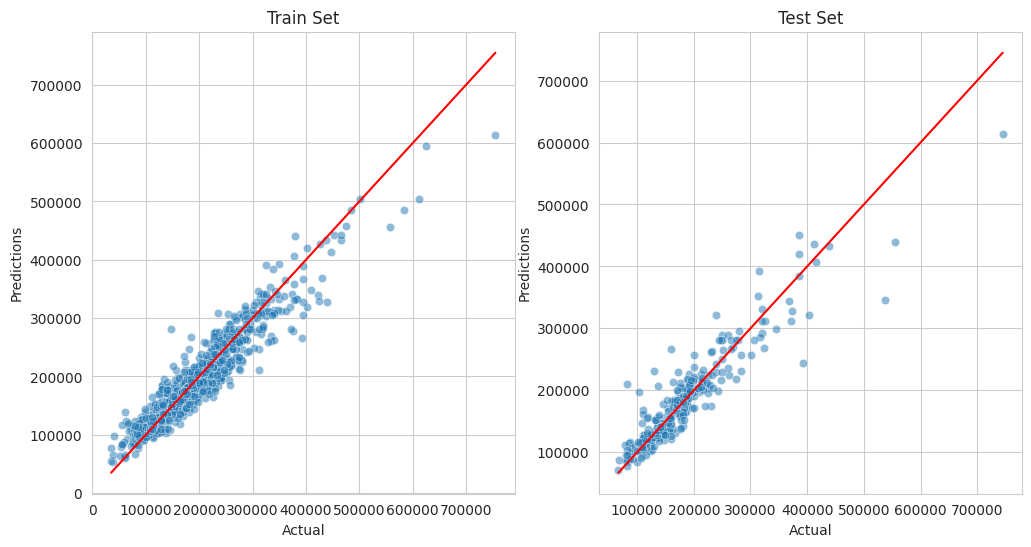

In [66]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Push files to Repo

In [67]:
import joblib
import os

version = 'v1'
file_path = f'/workspace/P5-Heritage-Housing/outputs/ml_pipeline/predict_SalePrice/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

In [68]:
X_train.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
618,774,1828,9,1822,2007
870,308,894,5,894,1962
92,432,964,5,876,1921
817,857,1689,8,1568,2002
302,843,1541,7,1541,2001


#### TrainSet: Features and Target

In [69]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [74]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [75]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

#### TestSet: Features and Target

In [76]:
X_test.head()

,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt
529,484,2515,6,2035,1957
491,240,1578,6,806,1941
459,352,1203,5,709,1950
279,505,2022,7,1160,1977
655,264,1092,6,525,1971


In [77]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [78]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [79]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

#### Modelling Pipeline

In [80]:
pipeline = best_regressor_pipeline

In [81]:
joblib.dump(value=pipeline, filename=f"{file_path}/pipeline.pkl")

['/workspace/P5-Heritage-Housing/outputs/ml_pipeline/predict_SalePrice/v1/pipeline.pkl']

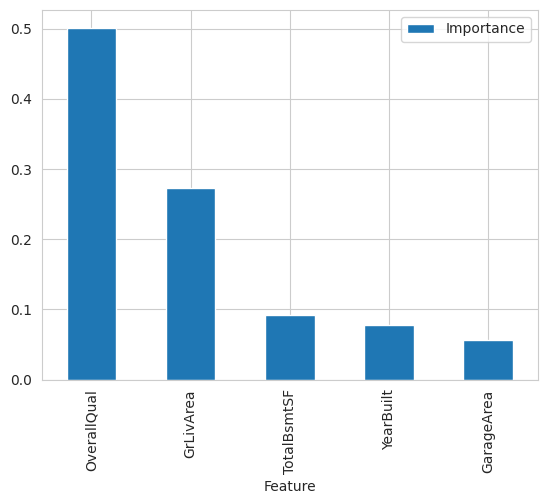

In [82]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

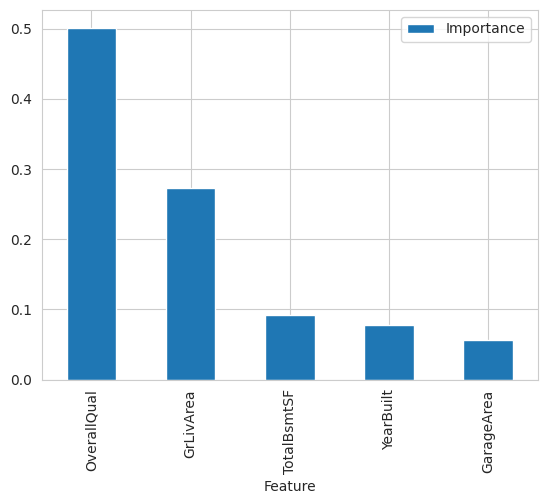

In [83]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')